# Joint Modeling end-to-end demo

Here we achieve the key goal of `blasé`: to make an end-to-end joint model for both the star and telluric spectrum.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import (SparseLinearEmulator, 
                            SparseLogEmulator, 
                            ExtrinsicModel,
                            InstrumentalModel)
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Set the wavelength limits

In [3]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in Data

In [4]:
from muler.hpf import HPFSpectrum
import pandas as pd
import glob

In [5]:
df = pd.read_csv('../../../blimp/data/tables/001_goldilocks_dropbox_847x22_v1p0.csv')
df = df[df.OBJECT.str.contains('WASP_69')].reset_index()
target_fn = df.file_basename[12]

In [6]:
path = '/Volumes/pecos/'
if not os.path.exists(path):
    path = '/media/gully/pecos/'

search_path = path+'HPF/Dropbox/**/*.spectra.fits'

In [7]:
fns = glob.glob(search_path, recursive=True)

In [8]:
absolute_path = [fn for fn in fns if target_fn in fn][0]

In [9]:
rawdata = HPFSpectrum(file=absolute_path, order=20)
data = rawdata.sky_subtract(method='vector').trim_edges((8, 2040)).deblaze().normalize()

In [10]:
scalar = np.nanpercentile(data.flux, 98)
data = data.divide(scalar, handle_meta='ff')

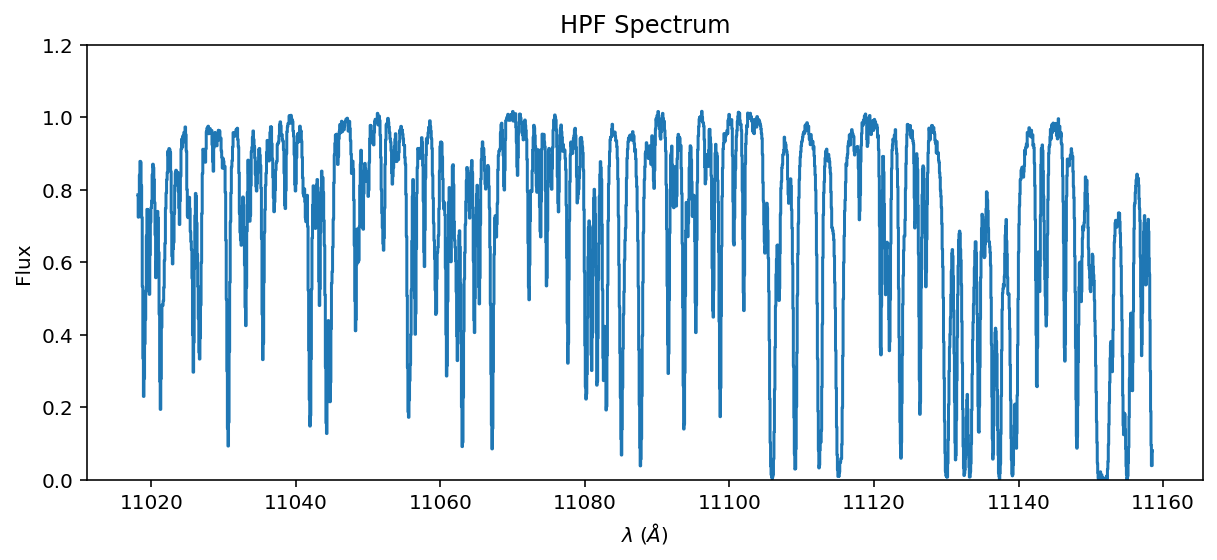

In [11]:
ax = data.plot()
ax.set_ylim(0, 1.2);

## Read in a precomputed synthetic stellar spectrum

In [12]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=wl_lo, wl_hi=wl_hi)
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()
continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")

## Read in a precomputed synthetic telluric spectrum

In [13]:
data.meta['header']['ENVTEM'], data.meta['header']['ENVHUM']

(63.529, 41.073)

That's 290 Kelvin and 41% humidity

In [14]:
fn = path+'/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp290_hum040.txt'

In [15]:
telluric_spectrum_full = TelFitSpectrum(path=fn).air_to_vacuum()

In [16]:
mask = (telluric_spectrum_full.wavelength.value > wl_lo) & (telluric_spectrum_full.wavelength.value < wl_hi)

In [17]:
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

Great! Let's clone the telluric spectrum with the LogEmulator.

In [18]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = telluric_spectrum.flux.value
telluric_flux = np.abs(telluric_flux)
telluric_lnflux = np.log(telluric_flux)

Below about -15 in log space, the flux becomes dominated by numerical artifacts.  That's okay, we will never perceive flux that is less than a ten-millionth of the continuum, so we can simply chop it off.  

In [19]:
telluric_lnflux[telluric_lnflux < -15] = -15

In [20]:
emulator = SparseLogEmulator(telluric_wl, telluric_lnflux, wing_cut_pixels=6000, prominence=0.01)

/home/gully/GitHub/blase/src/blase/emulator.py:363: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.flux_active, dtype=torch.float64, device=device


Initializing a sparse model with 265 spectral lines


In [21]:
device

'cuda'

In [22]:
emulator.target.device

device(type='cuda', index=0)

In [23]:
emulator.to(device)

SparseLogEmulator()

In [24]:
emulator.target.device

device(type='cuda', index=0)

## Overplot

(11060.0, 11120.0)

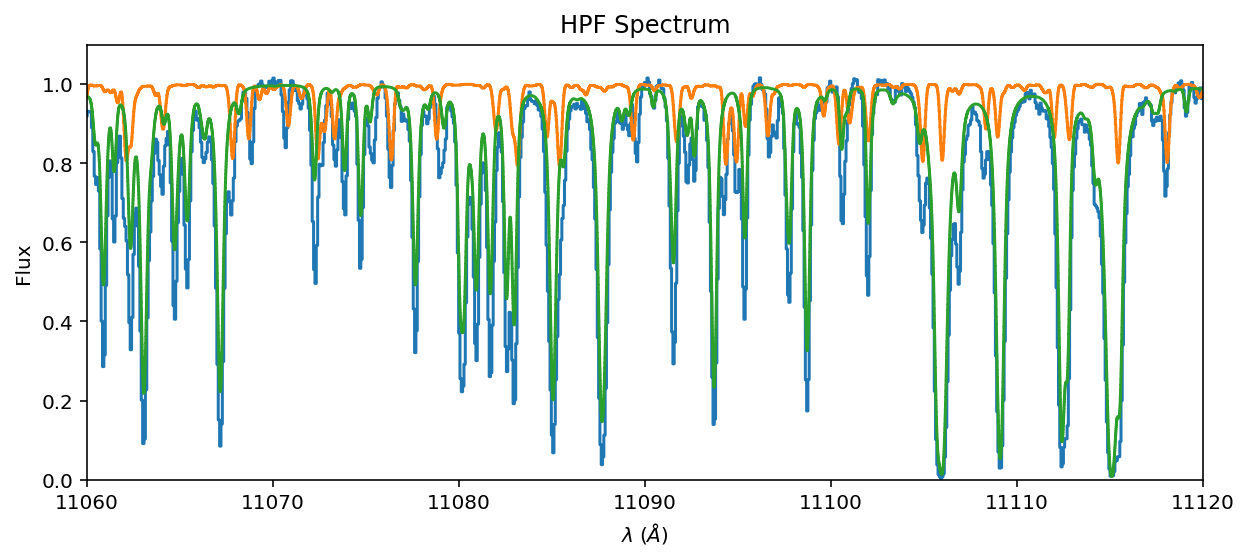

In [25]:
ax = data.plot(ylo=0, yhi=1.1);
stellar_spectrum.rotationally_broaden(2.1).rv_shift(23.0).instrumental_broaden().plot(ax=ax)
telluric_spectrum.instrumental_broaden().plot(ax=ax)
ax.set_xlim(11_060, 11_120)

## Train the emulator.

In [26]:
emulator.lam_centers.requires_grad = True
emulator.amplitudes.requires_grad = True
emulator.sigma_widths.requires_grad = True
emulator.gamma_widths.requires_grad = True

In [27]:
emulator

SparseLogEmulator()

In [28]:
emulator.target.device

device(type='cuda', index=0)

In [29]:
emulator.optimize(epochs=10_000, LR=0.03)

Training Loss: 0.00005990: 100%|██████████| 10000/10000 [01:57<00:00, 84.76it/s]


In [30]:
with torch.no_grad():
    telluric_post = emulator.forward().cpu().numpy()

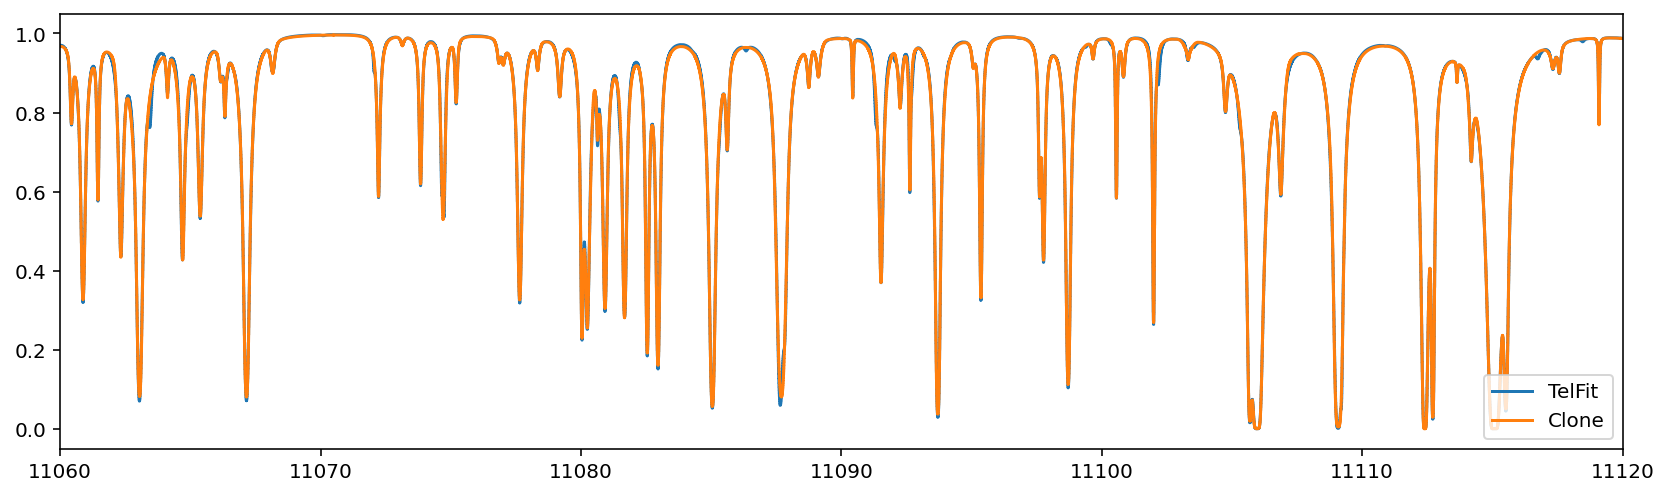

In [31]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux, label='TelFit')
plt.step(telluric_wl, telluric_post, label='Clone')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

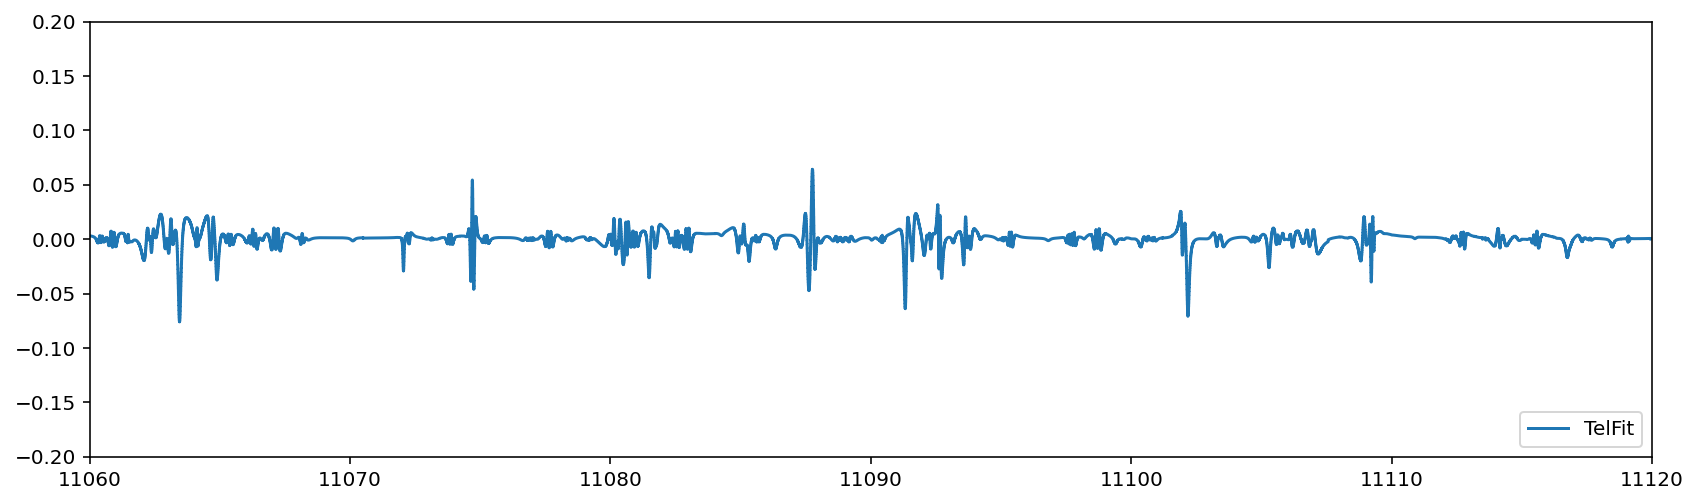

In [32]:
residual = telluric_flux-telluric_post

residual_mask = (telluric_wl >11_060) & (telluric_wl<11_120)

residual=residual[residual_mask]

plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux-telluric_post,ms=1, label='TelFit')
plt.xlim(11_060, 11_120)
plt.ylim(-0.2, 0.2)
plt.legend(loc='lower right');

In [33]:
np.std(telluric_flux)/np.std(residual)

39.19174089186145

In [34]:
np.std(residual)

0.008060343084567509

## Clone the stellar model

In [35]:
stellar_spectrum.wavelength.value.shape

(14999,)

In [36]:
stellar_wl = stellar_spectrum.wavelength.value
stellar_flux = stellar_spectrum.flux.value
stellar_emulator = SparseLinearEmulator(stellar_wl, 
                             stellar_flux, 
                             wing_cut_pixels=6000, prominence=0.01)

Initializing a sparse model with 440 spectral lines


/home/gully/GitHub/blase/src/blase/emulator.py:363: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.flux_active, dtype=torch.float64, device=device


In [37]:
stellar_emulator.to(device)

SparseLinearEmulator()

In [38]:
stellar_emulator.optimize(epochs=10_000, LR=0.003)

Training Loss: 0.00012325: 100%|██████████████| 300/300 [00:05<00:00, 50.74it/s]


In [39]:
with torch.no_grad():
    stellar_post = stellar_emulator.forward().cpu().numpy()

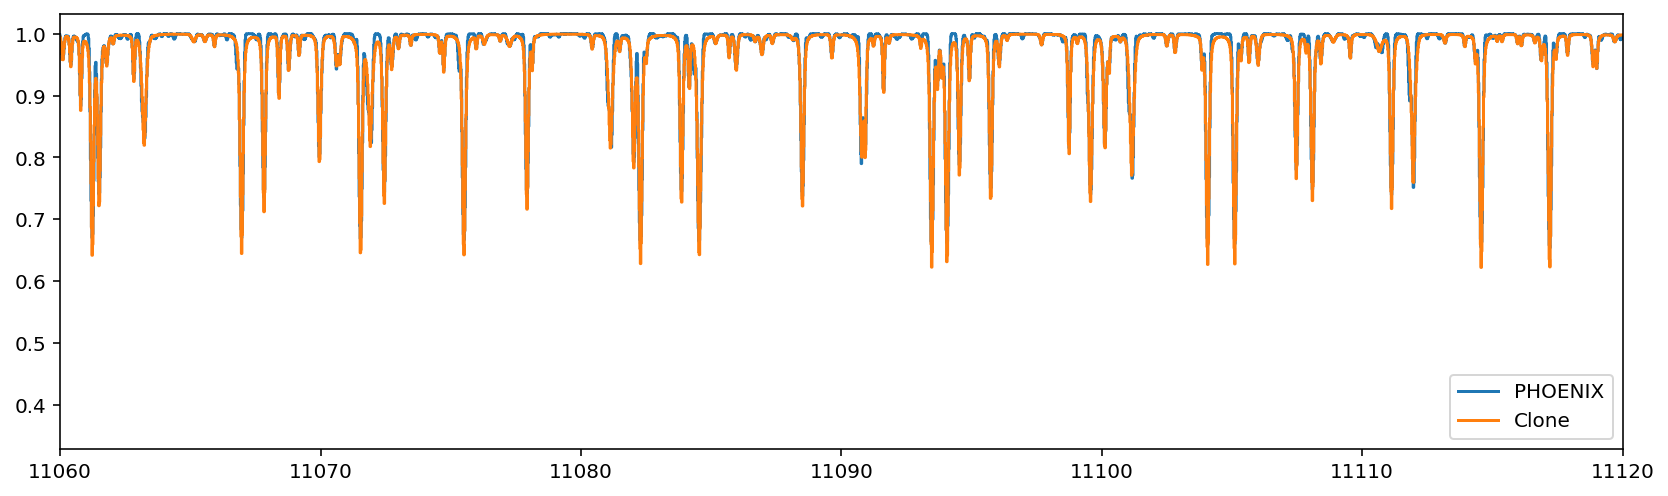

In [40]:
plt.figure(figsize=(14,4))
plt.step(stellar_wl, stellar_flux, label='PHOENIX')
plt.step(stellar_wl, stellar_post, label='Clone')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

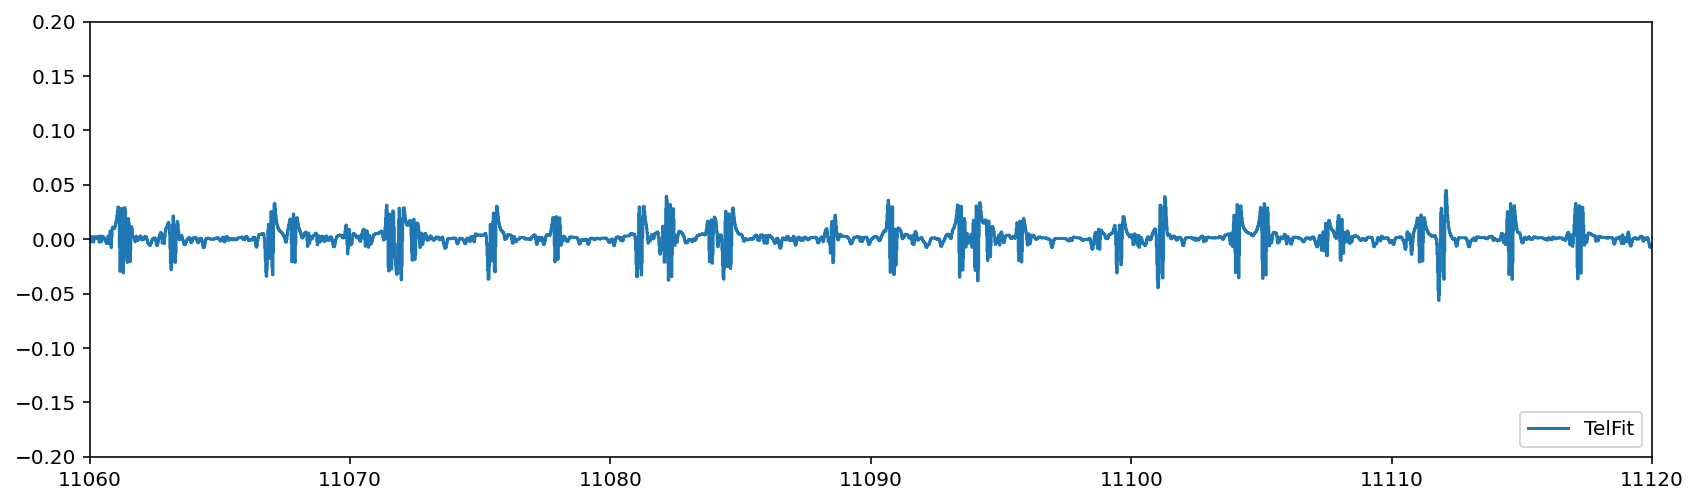

In [41]:
residual = stellar_flux-stellar_post

residual_mask = (stellar_wl >11_060) & (stellar_wl<11_120)

residual=residual[residual_mask]

plt.figure(figsize=(14,4))
plt.step(stellar_wl[residual_mask], residual,ms=1, label='PHOENIX residual')
plt.xlim(11_060, 11_120)
plt.ylim(-0.2, 0.2)
plt.legend(loc='lower right');

## Tune the extrinsic model

In [42]:
ext_model = ExtrinsicModel(stellar_wl)
ext_model.to(device)

ExtrinsicModel()

In [43]:
with torch.no_grad():
    ext_model.ln_vsini *=0 
    ext_model.ln_vsini += np.log(1.1)

    stellar_emulator.radial_velocity *=0
    stellar_emulator.radial_velocity +=23

In [44]:
with torch.no_grad():
    stellar_shift = stellar_emulator.forward()
    conv_flux = ext_model.forward(stellar_shift).cpu()

In [45]:
conv_flux.shape

torch.Size([14999])

## Combine the two emulators

The telluric emulator has much finer sampling than the stellar emulator.  Let's spot-check if that makes a difference:

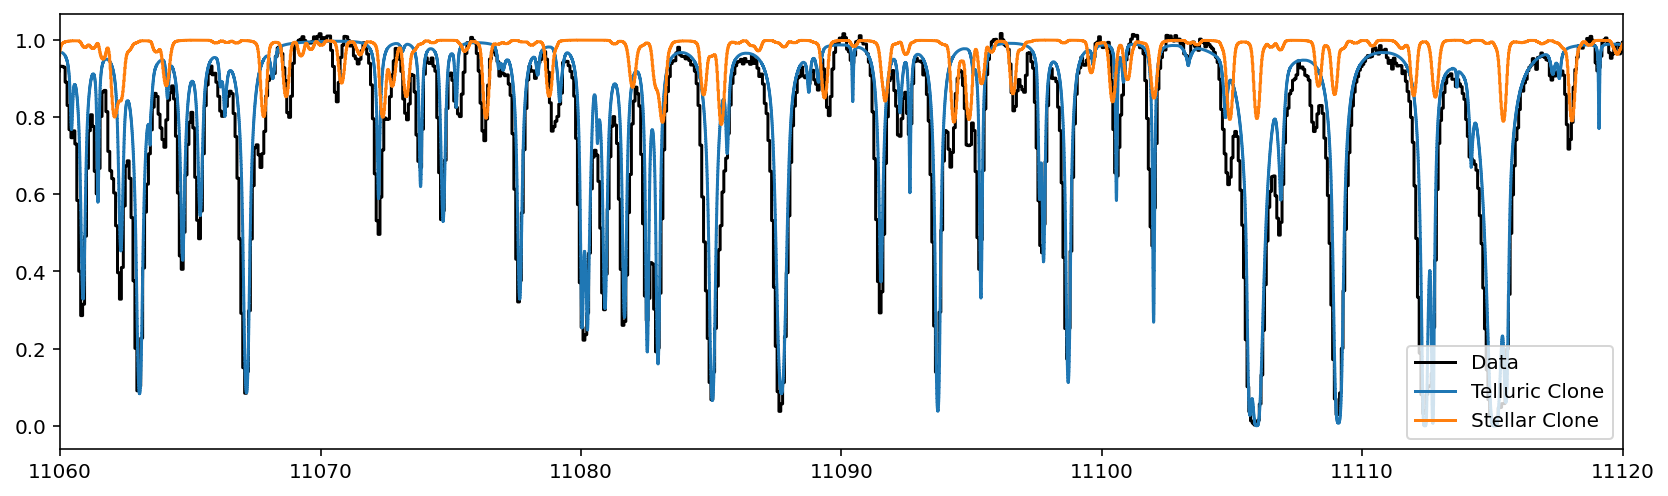

In [46]:
plt.figure(figsize=(14,4))

plt.step(data.wavelength, data.flux, label='Data', color='k')

plt.step(telluric_wl, telluric_post, label='Telluric Clone')

plt.step(stellar_wl, conv_flux, label='Stellar Clone')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

Ok! We have two emulators, and now need to combine them.  The problem is that they have different shapes:

In [47]:
telluric_post.shape, conv_flux.shape

((120239,), torch.Size([14999]))

### Resample the telluric model to the stellar native wavelength coordinates

In [48]:
from blase import utils

In [49]:
wl_lo, wl_hi

(10940, 11240)

In [50]:
lambda_Z = utils.doppler_grid(wl_lo, wl_hi, 0.5)

In [51]:
delta_lambda = np.diff(lambda_Z)
np.min(delta_lambda), np.max(delta_lambda)

(0.018245971223223023, 0.018746267784081283)

In [52]:
init_state_dict = emulator.state_dict()

resamp_Telluric_emulator = SparseLogEmulator(wl_native=lambda_Z, 
                                             lnflux_native=None,prominence=None, wing_cut_pixels=6000, 
                                             init_state_dict=init_state_dict)

In [57]:
resamp_Telluric_emulator.to(device)

SparseLogEmulator()

In [58]:
resamp_Telluric_emulator.state_dict().keys()

odict_keys(['lam_centers', 'amplitudes', 'sigma_widths', 'gamma_widths', 'a_coeff', 'b_coeff', 'c_coeff', 'radial_velocity'])

In [59]:
with torch.no_grad():
    resamp_telluric_flux = resamp_Telluric_emulator.forward()

In [62]:
emulator.wl_native.shape

torch.Size([120239])

In [60]:
resamp_telluric_flux.shape 

torch.Size([16221])

Amazing!

## Compute the joint model

In [ ]:
M_joint_flux = conv_flux * resamp_telluric_flux.cpu()

In [ ]:
plt.figure(figsize=(14,4))

plt.step(data.wavelength, data.flux, label='Data', color='k')

plt.step(stellar_wl, M_joint_flux, label='Joint model')
plt.xlim(11_060, 11_120)
plt.legend(loc='lower right');

Yay! Let's refine the joint model with an instrument model!

## Instrument model and resampling

In [ ]:
from tqdm import trange
import torch.optim as optim
from torch import nn

In [ ]:
from blase.emulator import InstrumentalModel

model = InstrumentalModel(
    data.spectral_axis.bin_edges.value.astype(np.float64), stellar_wl
)
model.to(device)

In [ ]:
ax = data.plot(ylo=0)
ax.axhline(1.0, color='k', linestyle='dashed')

In [ ]:
data_target = torch.tensor(
    data.flux.value.astype(np.float64), device=device, dtype=torch.float64
)

In [ ]:
data_wavelength = torch.tensor(
    data.wavelength.value.astype(np.float64), device=device, dtype=torch.float64
)

In [ ]:
loss_fn = nn.MSELoss(reduction="sum")

In [ ]:
import copy

### Fix some parameters

In [ ]:
resamp_Telluric_emulator.lam_centers.requires_grad = False
resamp_Telluric_emulator.amplitudes.requires_grad = True
resamp_Telluric_emulator.sigma_widths.requires_grad = True
resamp_Telluric_emulator.gamma_widths.requires_grad = True

In [ ]:
stellar_emulator.lam_centers.requires_grad = False
stellar_emulator.amplitudes.requires_grad = True
stellar_emulator.sigma_widths.requires_grad = True
stellar_emulator.gamma_widths.requires_grad = True

In [ ]:
optimizer = optim.Adam(
    list(filter(lambda p: p.requires_grad, ext_model.parameters()))
    + list(filter(lambda p: p.requires_grad, stellar_emulator.parameters()))
    + list(filter(lambda p: p.requires_grad, resamp_Telluric_emulator.parameters())),
    0.01,
    amsgrad=True,
)
n_epochs = 300
losses = []

with torch.no_grad():
    telluric_amplitude_init = copy.deepcopy(torch.exp(resamp_Telluric_emulator.amplitudes.detach()))
    stellar_amplitude_init = copy.deepcopy(torch.exp(stellar_emulator.amplitudes.detach())

# Define the prior on the amplitude
def ln_prior(amplitude_vector, amplitude_init):
    """
    Prior for the amplitude vector
    """
    amplitude_difference = amplitude_init - torch.exp(amplitude_vector)
    return 0.5 * torch.sum((amplitude_difference ** 2) / (0.01 ** 2))

In [ ]:
# We need uncertainty to be able to compute the posterior
# Assert fixed per-pixel uncertainty for now
per_pixel_uncertainty = torch.tensor(0.004, device=device, dtype=torch.float64)

In [ ]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    resamp_Telluric_emulator.train()
    stellar_emulator.train()
    ext_model.train()
    model.train()
    tellurics = resamp_Telluric_emulator.forward()
    star = stellar_emulator.forward()
    conv_star = ext_model.forward(star)
    joint_model = conv_star * tellurics
    yhat = model.forward(joint_model)
    loss = loss_fn(yhat / per_pixel_uncertainty, data_target / per_pixel_uncertainty)
    loss += ln_prior(resamp_Telluric_emulator.amplitudes, telluric_amplitude_init)
    loss += ln_prior(stellar_emulator.amplitudes, stellar_amplitude_init)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

In [ ]:
with torch.no_grad():
    tellurics = resamp_Telluric_emulator.forward()
    star = stellar_emulator.forward()
    conv_star = ext_model.forward(star)
    joint_model = conv_star * tellurics
    yhat = model.forward(joint_model)
    stellar_inst = model.forward(conv_star)
    telluric_inst = model.forward(tellurics)

In [ ]:
plt.figure(figsize=(14,4))
plt.step(data.wavelength, data_target.cpu(), label='Data', color='k', lw=1.5)
plt.step(data.wavelength, yhat.cpu(), label='Final model', alpha=1.0, lw=1.5)

#plt.xlim(11_060, 11_120)
plt.xlim(11_018, 11_080)

plt.legend(loc='lower right');

In [ ]:
plt.figure(figsize=(14,4))
plt.step(data.wavelength, data_target.cpu()-yhat.cpu(), label='Data', color='k', lw=1.5)

plt.ylim(-0.2, 0.2)
plt.xlim(11_018, 11_080)

plt.legend(loc='lower right');

In [ ]:
plt.figure(figsize=(14,4))
plt.step(data.wavelength, data_target.cpu(), label='Data', color='k', lw=1.5)
#plt.step(data.wavelength, yhat.cpu(), label='Final model', alpha=1.0, lw=1.5)

plt.fill_between(data.wavelength, 1.0, stellar_inst.cpu(), color='#e67e22', alpha=0.4, label='Star', step='mid')
plt.fill_between(data.wavelength, stellar_inst.cpu(), yhat.cpu(), color='#3498db', alpha=0.4, 
                 label='Telluric', step='mid')

#plt.xlim(11_060, 11_120)
plt.xlim(11_018, 11_080)

plt.legend(loc='lower right');

In [ ]:
with torch.no_grad():
    stellar_emulator.radial_velocity *=0
    star = stellar_emulator.forward()

In [ ]:
plt.figure(figsize=(14,4))

plt.step(stellar_wl, stellar_emulator.flux_native, label='Native Flux',color='k', lw=1.0)
plt.step(stellar_wl, star.cpu(), label='Semi-empirical star', lw=1.0, color='#e67e22')

#plt.step(stellar_wl, joint_model, label='Joint model')
#plt.step(data.wavelength, yhat, label='Final model', alpha=1.0, lw=1.5)

#plt.step(data.wavelength, stellar_inst, label='Star', alpha=0.6, lw=1.5)
#plt.step(data.wavelength, telluric_inst, label='Tellurics', alpha=0.6, lw=1.5, color='g')

#plt.xlim(11_060, 11_120)
plt.xlim(11_018, 11_080)

plt.legend(loc='lower right');

In [ ]:
plt.figure(figsize=(14,4))

plt.step(telluric_wl, telluric_flux, label='Native Flux',color='k', lw=1.0)
plt.step(stellar_wl, tellurics.cpu(), label='Semi-empirical tellurics', lw=1.0, color='#3498db')

#plt.xlim(11_060, 11_120)
plt.xlim(11_018, 11_080)

plt.legend(loc='lower right');

Yay! It works end-to-end!

In [ ]:
import numpy as np

In [ ]:
from astropy import constants as const
from astropy import units as u


In [ ]:
res = 55_000

In [ ]:
dv = np.array(0.5) # 1/(res*10)* 299_792.458

In [ ]:
dv

In [ ]:
lam_0 = 8038.0 #stellar_emulator.wl_native.min().numpy()
lam_max = 12849.0#stellar_emulator.wl_native.max().numpy()

In [ ]:
#import torch

In [ ]:
cc = const.c.to(u.km/u.s).value

In [ ]:
#vel_max = 299_792.458*(lam_max - lam_0)/lam_0
vel_max = cc*np.log(lam_max/lam_0)

In [ ]:
n_points = vel_max/dv

In [ ]:
n_points

In [ ]:
vel_vector = np.linspace(0.0, vel_max, n_points)

In [ ]:
lam_vector = lam_0 * torch.exp(vel_vector/cc)

In [ ]:
vel_vector

In [ ]:
lam_vector

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(lam_vector)

In [ ]:
np.diff(stellar_wl)

In [ ]:
plt.plot(np.diff(lam_vector))

In [ ]:
plt.plot(lam_vector[1:], 300_000*np.diff(lam_vector)/lam_vector[1:])
plt.ylim(0,2)

In [ ]:
len(lam_vector)

In [ ]:
np.diff(lam_vector)